In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 9.3 MB/s eta 0:00:00


In [ ]:
! pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost import XGBClassifier
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Загрузка и предобработка данных

In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [ ]:
train_df.head(3)

,name,_id,host_name,location_cluster,location,lat,lon,type_house,sum,min_days,amt_reviews,last_dt,avg_reviews,total_host,target
0,Belle Harbor 4 BR 2 bath- 1 bl from Beach,40327248,Sarina,Queens,Neponsit,40.57215,-73.85822,Entire home/apt,350,2,5,2019-07-07,2.88,1,334
1,"Come see Brooklyn, New York",13617520,Howard T.,Brooklyn,Clinton Hill,40.69172,-73.96934,Shared room,40,5,8,2015-02-25,0.13,1,0
2,Large 2Br on W71st & Columbus Feb 19-28,26754726,Julie,Manhattan,Upper West Side,40.77673,-73.98011,Entire home/apt,200,5,0,NaN,NaN,1,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36671 entries, 0 to 36670
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              36662 non-null  object 
 1   _id               36671 non-null  int64  
 2   host_name         36653 non-null  object 
 3   location_cluster  36671 non-null  object 
 4   location          36671 non-null  object 
 5   lat               36671 non-null  float64
 6   lon               36671 non-null  float64
 7   type_house        36671 non-null  object 
 8   sum               36671 non-null  int64  
 9   min_days          36671 non-null  int64  
 10  amt_reviews       36671 non-null  int64  
 11  last_dt           29169 non-null  object 
 12  avg_reviews       29169 non-null  float64
 13  total_host        36671 non-null  int64  
 14  target            36671 non-null  int64  
dtypes: float64(3), int64(6), object(6)
memory usage: 4.2+ MB


In [ ]:
train_df.nunique()

,0
name,36076
_id,29141
host_name,9629
location_cluster,5
location,220
lat,16968
lon,13295
type_house,3
sum,625
min_days,96


In [ ]:
train_df.isna().sum()

,0
name,9
_id,0
host_name,18
location_cluster,0
location,0
lat,0
lon,0
type_house,0
sum,0
min_days,0


In [ ]:
test_df.isna().sum()

,0
name,7
_id,0
host_name,3
location_cluster,0
location,0
lat,0
lon,0
type_house,0
sum,0
min_days,0


Приведем к формату datetime колонку с датой. Применим методы замены NaN в тренировочном и тестовом датасетах. Для последней даты посещения установим среднее значение даты по каждой из таблиц, средний рейтинг будем считать нулевым, если о нем нет данных.

In [ ]:
train_df.last_dt = pd.to_datetime(train_df.last_dt)
mean_date = train_df.last_dt.dropna().mean()
train_df.last_dt = train_df.last_dt.fillna(mean_date)
train_df.avg_reviews = train_df.avg_reviews.fillna(0)

In [ ]:
test_df.last_dt = pd.to_datetime(test_df.last_dt)
mean_date = test_df.last_dt.dropna().mean()
test_df.last_dt = test_df.last_dt.fillna(mean_date)
test_df.dropna(subset = 'last_dt', inplace=True)
test_df.avg_reviews = test_df.avg_reviews.fillna(0)

Название для каждого объекта уникально. Эту колонку можно было бы дополнительно обработать с помощью методов анализа текста. Имя владельца могло бы быть полезно, но у нас уже есть колонка с информацией о количестве объектов в собственности - таким образом, эта колонка уже дает информацию об уникальном владельце.

In [ ]:
train_df.drop(columns = ['name', '_id', 'host_name'], inplace = True)
test_df.drop(columns = ['name', '_id', 'host_name'], inplace = True)

Преобразуем данные о дате в формат год-месяц-день-час-день недели

In [ ]:
train_df['year'] = train_df.last_dt.dt.year
train_df['month'] = train_df.last_dt.dt.month
train_df['day'] = train_df.last_dt.dt.day
train_df['hour'] = train_df.last_dt.dt.hour
train_df['weekday'] = train_df.last_dt.dt.weekday

Для преобразования координат используем карте

In [ ]:
def toCartesian(lat, lon):
    R = 6378  #радиус земли
    x = R * np.cos(np.radians(lat)) * np.cos(np.radians(lon))
    y = R * np.cos(np.radians(lat)) * np.sin(np.radians(lon))
    z = R * np.sin(np.radians(lat))
    return x, y, z

train_df['x'], train_df['y'], train_df['z'] =  toCartesian(train_df.lat, train_df.lon)

In [ ]:
test_df['year'] = test_df.last_dt.dt.year
test_df['month'] = test_df.last_dt.dt.month
test_df['day'] = test_df.last_dt.dt.day
test_df['hour'] = test_df.last_dt.dt.hour
test_df['weekday'] = test_df.last_dt.dt.weekday

test_df['x'], test_df['y'], test_df['z'] =  toCartesian(test_df.lat, test_df.lon)

In [ ]:
combined_df = pd.concat([train_df, test_df], axis=0)

In [ ]:
combined_df.columns

Index(['location_cluster', 'location', 'lat', 'lon', 'type_house', 'sum',
       'min_days', 'amt_reviews', 'last_dt', 'avg_reviews', 'total_host',
       'target', 'year', 'month', 'day', 'hour', 'weekday', 'x', 'y', 'z'],
      dtype='object')

In [ ]:
cat_cols = ['location_cluster', 'location', 'type_house']

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
cat_df = combined_df[cat_cols].copy()


for col in cat_cols:
    cat_df[col] = le.fit_transform(combined_df[col])

In [ ]:
cat_train_encoded = cat_df.iloc[:len(train_df)]
cat_test_encoded = cat_df.iloc[len(train_df):]

cat_train_encoded.index = train_df.index
cat_test_encoded.index = test_df.index

In [ ]:
trainNumeric = train_df.drop(columns= cat_cols).drop(columns= ['lat', 'lon', 'last_dt','target'])

trainEncoded = trainNumeric.merge(cat_train_encoded, left_index=True, right_index=True)

In [ ]:
testNumeric = test_df.drop(columns= cat_cols).drop(columns= ['lat', 'lon', 'last_dt'])
testEncoded = testNumeric.merge(cat_test_encoded, left_index=True, right_index=True)

In [ ]:
trainEncoded.head()

,sum,min_days,amt_reviews,avg_reviews,total_host,year,month,day,hour,weekday,x,y,z,location_cluster,location,type_house
0,350,2,5,2.88,1,2019,7,7,0,6,1346.886051,-4653.657189,4148.283589,3,139,0
1,40,5,8,0.13,1,2015,2,25,0,2,1335.464615,-4647.930090,4158.384800,1,41,2
2,200,5,0,0.00,1,2018,10,4,1,3,1332.886752,-4642.245709,4165.555387,2,202,0
3,65,2,18,0.64,1,2018,11,4,0,6,1334.485804,-4638.867355,4168.805741,2,94,1
4,99,2,26,0.76,1,2019,6,23,0,6,1338.495759,-4646.258919,4159.277721,1,28,1


In [ ]:
fig, ax = plt.subplots(figsize = (7, 4))
sns.histplot(train_df, x= 'target')

# Финальная версия модели

In [ ]:
X = trainEncoded
y = train_df.target

Выбор базовой модели

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Ridge" : Ridge(alpha=0.8),
    "Lasso" : Lasso(alpha=0.2),
    "ElasticNet" : ElasticNet(alpha=0.2, l1_ratio=0.2),
    "XGBoost": XGBRegressor(),
    "MLPRegressor" : MLPRegressor(hidden_layer_sizes=(400, 70), activation='relu'),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{name}: MSE = {mse:.2f}")

Linear Regression: MSE = 14270.72
Random Forest: MSE = 10355.07
Ridge: MSE = 14292.86
Lasso: MSE = 14373.73
ElasticNet: MSE = 14411.38
XGBoost: MSE = 10562.04
MLPRegressor: MSE = 12576.75


Лучшие результаты получились у XGBoost и RandomForest, однако на тестовом наборе получены неудовлетворительные результаты для RandomForest, модель переобучалась. Поэтому последующие эксперименты проводились на XGBoost.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Для подбора оптимальных гиперпараметров применена optuna.

In [ ]:
def params_optimizer(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
        'random_state': 42,
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test, y_pred)

study = optuna.create_study(direction='minimize')
study.optimize(params_optimizer, n_trials=50,  show_progress_bar=True)

print("Лучшие параметры:", study.best_params)
print("Лучшее значение MSE:", study.best_value)

Примененим для валидации не просто разбиение на 2 выборки, а кросс-валидацию. Это позволит оптимизировать гиперпараметры так, чтобы модель давала хорошие результаты на всех фолдах.

In [ ]:
def label_enc_opt(trial):
  #не подбирает оптимальные коды для признаков, так как они кодируются labelencoder
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,

    }

    # Кросс-валидация
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []

    for train_idx, val_idx in kf.split(X_train_encoded):
        X_fold_train, X_fold_val = X_train_encoded.iloc[train_idx], X_train_encoded.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = XGBRegressor(**params)
        model.fit(X_fold_train, y_fold_train)

        y_pred = model.predict(X_fold_val)
        mse_scores.append(mean_squared_error(y_fold_val, y_pred))

    return np.mean(mse_scores)


study = optuna.create_study(direction='minimize')
study.optimize(label_enc_opt, n_trials=50, show_progress_bar=True)


print("Лучшие параметры:", study.best_params)
print("Лучшее MSE:", study.best_value)


# best_model = XGBRegressor(**study.best_params, random_state=42)
# best_model.fit(X_train_encoded, y_train)


# y_pred = best_model.predict(X_test_encoded)
# print("Val MSE:", mean_squared_error(y_test, y_pred))

[I 2025-03-27 19:09:56,204] A new study created in memory with name: no-name-889a5d1b-3bb6-43d0-b22a-ae738bd7d386


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-27 19:10:07,715] Trial 0 finished with value: 11335.7267578125 and parameters: {'n_estimators': 391, 'max_depth': 7, 'learning_rate': 0.21947960261687585, 'subsample': 0.9466711899963607, 'colsample_bytree': 0.7370584040907786, 'gamma': 0.016017617530465156, 'reg_alpha': 5.763592882407124, 'reg_lambda': 0.7510265117155446}. Best is trial 0 with value: 11335.7267578125.
[I 2025-03-27 19:11:14,796] Trial 1 finished with value: 11131.865234375 and parameters: {'n_estimators': 835, 'max_depth': 10, 'learning_rate': 0.1925715253499754, 'subsample': 0.9391625032423487, 'colsample_bytree': 0.6896962804463286, 'gamma': 0.7599681378197763, 'reg_alpha': 1.3545238592612652, 'reg_lambda': 4.544776863102793}. Best is trial 1 with value: 11131.865234375.
[I 2025-03-27 19:12:24,477] Trial 2 finished with value: 11181.9666015625 and parameters: {'n_estimators': 600, 'max_depth': 10, 'learning_rate': 0.12629431798990864, 'subsample': 0.6435804677257257, 'colsample_bytree': 0.91254982079358, 

ValueError: Found input variables with inconsistent numbers of samples: [7335, 12224]

Ошибка ValueError связана с закомментированным кодом, переданы неправильные значения. Не перезапускался оптимизатор из-за ограниченного времени до дедлайна( Исправлена в коде ниже:

In [ ]:
best_model = XGBRegressor(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)


y_pred = best_model.predict(X_test)
print("Val MSE:", mean_squared_error(y_test, y_pred))

Val MSE: 9993.537109375


In [ ]:
y_pred = best_model.predict(testEncoded)
submition = pd.read_csv('./sample_submition.csv')
submition['prediction'] = y_pred
submition.to_csv("/content/final_optuna.csv", index=False)

#**Intro**

1) Для обработки категориальных данных применен Label Encoding, так как One Hot Encoding мог создать слишком большое число признаков с малым "вкладом" каждого из признаков. Target Encoding также рассматривался для одной из спецификаций и представлен ниже как второй вариант доработки модели. Однако несмотря на подбор оптимального способа трансформации, результат был хуже на тестовых данных. Широта и долгота были преобразованы в декартовы координаты (x, y, z) в трехмерном пространстве, где Земля представлена как сфера с радиусом
R = 6378 км. Колонка с датами была преобразована на отдельные колонки с указанием на год, месяц, день, час, день недели. Были исключены признаки с названием объекта, id объекта и именем владельца. Применена обработка пропущенных значений: для дат замена средним значением, для отсутствующих данных о рейтинге считалось, что рейтинг 0.

2) Выбран алгоритм XGBRegressor, так как на валидации и тестовых данных были получены более высокие метрики и более стабильные результаты. Эта модель подходит для больших объемов данных, особенно если присутствуют признаки, которые вносят малый вклад, достаточно эффективно борется с выбросами в данных.  

3) Для подбора гиперпараметров применена Optuna

4) Валидация проводилась с применением K-fold, чтобы найти более стабильное значение метрики при измерении на всех фолдах.

# Второй вариант доработки базовой модели

Применен другой способ кодирования категориальных признаков - TargetEncoder

In [ ]:
train_df.head()

In [ ]:
train_df.drop(columns= ['lat', 'lon', 'last_dt'], inplace=True)

In [ ]:
train_df.head()

,location_cluster,location,type_house,sum,min_days,amt_reviews,avg_reviews,total_host,target,year,month,day,hour,weekday,x,y,z
0,Queens,Neponsit,Entire home/apt,350,2,5,2.88,1,334,2019,7,7,0,6,1346.886051,-4653.657189,4148.283589
1,Brooklyn,Clinton Hill,Shared room,40,5,8,0.13,1,0,2015,2,25,0,2,1335.464615,-4647.930090,4158.384800
2,Manhattan,Upper West Side,Entire home/apt,200,5,0,0.00,1,0,2018,10,4,1,3,1332.886752,-4642.245709,4165.555387
3,Manhattan,Harlem,Private room,65,2,18,0.64,1,0,2018,11,4,0,6,1334.485804,-4638.867355,4168.805741
4,Brooklyn,Bushwick,Private room,99,2,26,0.76,1,155,2019,6,23,0,6,1338.495759,-4646.258919,4159.277721


In [ ]:
test_df.drop(columns= ['lat', 'lon', 'last_dt'], inplace=True)

In [ ]:
test_df.head()

,location_cluster,location,type_house,sum,min_days,amt_reviews,avg_reviews,total_host,year,month,day,hour,weekday,x,y,z
0,Brooklyn,Sunset Park,Entire home/apt,399,1,0,0.00,5,2018,10,4,3,3,1333.692530,-4650.479967,4156.102058
1,Brooklyn,Bedford-Stuyvesant,Private room,43,1,4,2.00,3,2019,6,10,0,0,1339.140675,-4647.848020,4157.294197
2,Manhattan,Hell's Kitchen,Entire home/apt,275,30,2,0.08,121,2017,9,17,0,6,1331.769179,-4643.703050,4164.288275
3,Brooklyn,Williamsburg,Private room,40,3,0,0.00,2,2018,10,4,3,3,1338.472745,-4645.874203,4159.714846
4,Brooklyn,Crown Heights,Private room,55,4,1,0.14,1,2018,12,2,0,6,1336.961605,-4648.951674,4156.761480


In [ ]:
X = train_df.drop(columns='target')
y = train_df.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
import optuna
from xgboost import XGBRegressor
from category_encoders import TargetEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.base import clone

def get_opt_params(trial):

    encoder = TargetEncoder(cols=cat_cols, smoothing=2.0)


    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'random_state': 42,
        'enable_categorical': False  # Отключаем встроенную обработку категорий
    }

    # Кросс-валидация
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = []

    for train_idx, val_idx in kf.split(X_train):
        X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        # TargetEncoder на фолде
        encoder_clone = clone(encoder)
        X_fold_train_encoded = encoder_clone.fit_transform(X_fold_train, y_fold_train)
        X_fold_val_encoded = encoder_clone.transform(X_fold_val)


        model = XGBRegressor(**params)
        model.fit(X_fold_train_encoded, y_fold_train)


        y_pred = model.predict(X_fold_val_encoded)
        mse_scores.append(mean_squared_error(y_fold_val, y_pred))

    return np.mean(mse_scores)

In [ ]:
# Оптимизация
study = optuna.create_study(direction='minimize')
study.optimize(get_opt_params, n_trials=50, show_progress_bar=True)


print("Лучшие параметры:", study.best_params)
print("Лучшее MSE:", study.best_value)

[I 2025-03-27 18:18:36,990] A new study created in memory with name: no-name-d98ed683-3131-4472-86fd-e030453eb3a9


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-03-27 18:18:43,171] Trial 0 finished with value: 10916.0857421875 and parameters: {'n_estimators': 447, 'max_depth': 3, 'learning_rate': 0.019477623838817616, 'subsample': 0.8546411512633001, 'colsample_bytree': 0.8478867750572159, 'gamma': 0.4618580897547877, 'reg_alpha': 7.109652094219655, 'reg_lambda': 3.1612890704989116}. Best is trial 0 with value: 10916.0857421875.
[I 2025-03-27 18:18:46,473] Trial 1 finished with value: 10690.0619140625 and parameters: {'n_estimators': 154, 'max_depth': 5, 'learning_rate': 0.029355681674239176, 'subsample': 0.6778957929050731, 'colsample_bytree': 0.9409901381544022, 'gamma': 0.47768207203083735, 'reg_alpha': 9.464788644091849, 'reg_lambda': 3.3620937223604344}. Best is trial 1 with value: 10690.0619140625.
[I 2025-03-27 18:19:45,082] Trial 2 finished with value: 10120.1390625 and parameters: {'n_estimators': 751, 'max_depth': 9, 'learning_rate': 0.010138674606209054, 'subsample': 0.807829109160437, 'colsample_bytree': 0.9160786868502404,

In [ ]:
best_encoder = TargetEncoder(cols=cat_cols)
X_train_encoded = best_encoder.fit_transform(X_train, y_train)
X_val_encoded = best_encoder.transform(X_test)

best_model = XGBRegressor(**study.best_params)
best_model.fit(X_train_encoded, y_train)

y_pred = best_model.predict(X_val_encoded)
print("Test MSE:", mean_squared_error(y_test, y_pred))

Test MSE: 10340.7353515625


In [ ]:
X_test_encoded = best_encoder.transform(test_df)

In [ ]:
best_model = XGBRegressor(**study.best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"MSE = {mse:.2f}")

MSE = 10108.44


Модель менее стабильна, не так эффективно обрабатывает категориальные данные и борется с переобучением.

#**Outro**
1) Проведен только поверхностный статистический анализ. Необходим более глубокий анализ связей между признаками, поиск значимости каждого признака и его вклад в таргет. Необходимо оценить, есть ли экстремальные значения в данных, какой характер связей между призаками и целевой переменной. Изучить влияние цены, площади, района, проверить выбросы - например, есть ли объекты с очень долгим простоем. Возможно построение линейной регрессии для оценки связи между факторами и целевой переменной и расчет уровня значимости для коэффициентов. Возможно, удалось бы найти признакии с малым "вкладом" в целевую переменную. Для количественных данных можно добавить нормализацию или стандартизацию в зависимости от распределения

2)  Добавить Feature Engineering:  думаю, был бы эффект от кластеризации дат по сезонам бронирования, праздничным/бедним дням; преобразованию географических данных по расстоянию до центра города (из широты и долготы и location) или разделения по зонам по расстоянию от центра; можно попробовать рассчитать активность хоста - из количества объектов, среднего количества отзывов на объекты; связь тип жилья-цена

3) Ансамбль: кажется логичным применить здесь бустинг с регрессией, потому что у регрессионных моделей были достаточно высокие значения MSE на данных без тщательной предобработки

Anastasia Bromberg, 13

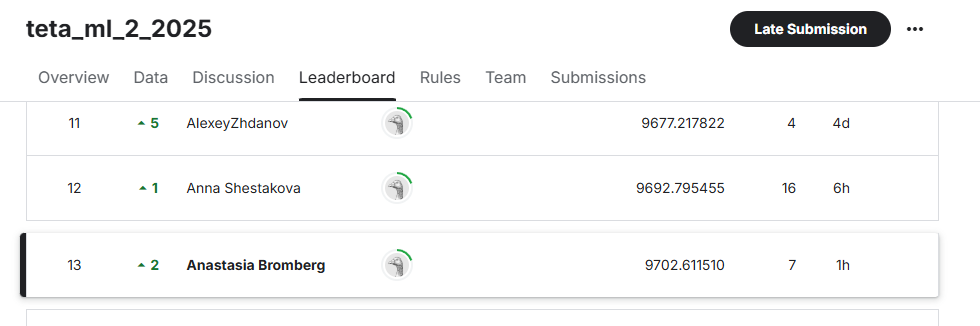